In [11]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

In [174]:

# Load the NetCDF file
data = xr.open_dataset('gistemp1200_GHCNv4_ERSSTv5.nc')

# Inspect the data structure
print(data)

<xarray.Dataset>
Dimensions:      (lat: 90, lon: 180, time: 1736, nv: 2)
Coordinates:
  * lat          (lat) float32 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
  * lon          (lon) float32 -179.0 -177.0 -175.0 -173.0 ... 175.0 177.0 179.0
  * time         (time) datetime64[ns] 1880-01-15 1880-02-15 ... 2024-08-15
Dimensions without coordinates: nv
Data variables:
    time_bnds    (time, nv) datetime64[ns] ...
    tempanomaly  (time, lat, lon) float32 ...
Attributes:
    title:        GISTEMP Surface Temperature Analysis
    institution:  NASA Goddard Institute for Space Studies
    source:       http://data.giss.nasa.gov/gistemp/
    Conventions:  CF-1.6
    history:      Created 2024-09-08 11:48:21 by SBBX_to_nc 2.0 - ILAND=1200,...


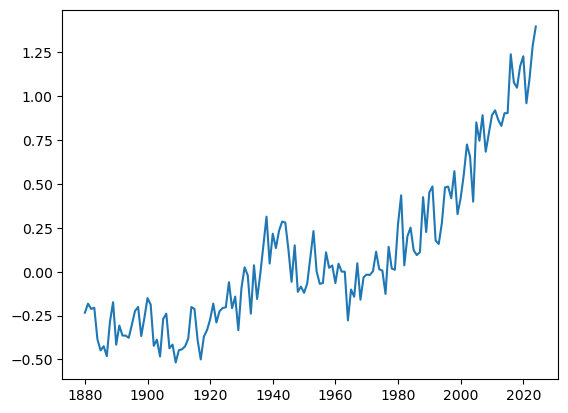

In [175]:
df = data['tempanomaly'].to_dataframe().reset_index()
df['year'] = df['time'].dt.year
average_tempanomaly_by_year = df.groupby('year')['tempanomaly'].mean().reset_index()
plt.plot(average_tempanomaly_by_year['year'], average_tempanomaly_by_year['tempanomaly'])
plt.show()

In [182]:
average_tempanomaly_by_year = df.groupby(['year', 'lat', 'lon'])['tempanomaly'].mean().reset_index()
average_tempanomaly_by_year["tempanomaly"] = average_tempanomaly_by_year["tempanomaly"].round(2)
average_tempanomaly_by_year.columns = ['Year', 'Latitude', 'Longitude', 'Temperature Anomaly']
average_tempanomaly_by_year = average_tempanomaly_by_year[average_tempanomaly_by_year['Year'] >= 1975]
average_tempanomaly_by_year.to_csv('word_temperature_anomalies.csv', index=False)

In [13]:
data = pd.read_csv('C:/Users/User/Mon Drive/DSB/2A HEC/Tooling for DS/climate-change-app/temp_anomalies_202308.csv')

# Create a world map of temperature anomalies
px.scatter_geo(data, lat='Latitude', lon='Longitude', color='Temperature Anomaly',
                     title="Global Temperature Anomalies (Aug 2023)",
                     color_continuous_scale="RdBu_r",
                     range_color=(-3, 3), opacity=0.3)  # Adjust range as necessary



In [18]:
data.columns

Index(['Date', 'Latitude', 'Longitude', 'Temperature Anomaly'], dtype='object')

In [25]:
temp_anomalies_year = df.groupby(['year', 'lat', 'lon'])['tempanomaly'].mean().reset_index()
temp_anomalies_year.columns = ['Year', 'Latitude', 'Longitude', 'Temperature Anomaly']
temp_anomalies_year = temp_anomalies_year[temp_anomalies_year['Year'] >= 2000]
temp_anomalies_year["Temperature Anomaly"] = temp_anomalies_year["Temperature Anomaly"].round(2)
temp_anomalies_year.to_csv('temp_anomalies_year.csv', index=False)

### City data

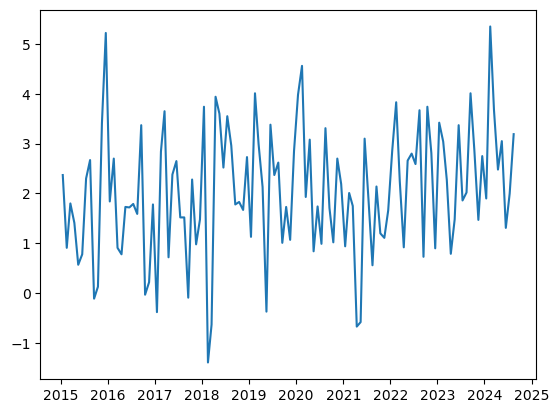

In [169]:
df_paris = df[(df["lat"] == 51.) & (df["lon"] == 1.)].copy()
df_paris["Date"] = df_paris["time"]
df_paris.set_index('Date', inplace=True)

temp = df_paris[df_paris["time"].dt.year >= 2015]
plt.plot(temp['time'], temp['tempanomaly'])

In [170]:
# Resample monthly data to yearly data (taking the mean temperature for each year)
df_paris_yearly = df_paris.resample('YE').mean()

# Reset the index for easier access
df_paris_yearly.reset_index(inplace=True)

# Convert the date to just the year (if needed)
df_paris_yearly['Year'] = df_paris_yearly['time'].dt.year

# Drop the 'Date' column (since we now have 'Year')
df_paris_yearly.drop(['time', 'lat', 'lon', 'year'], axis=1, inplace=True)

In [156]:
from sklearn.linear_model import Ridge

df_train = df_paris_yearly[df_paris_yearly['Year'] >= 1975]

ridge = Ridge()
ridge.fit(df_train['Year'].values.reshape(-1, 1), df_train['tempanomaly'].values)
df_pred = pd.DataFrame({'Year': range(2025, 2101)})
df_pred['tempanomaly'] = ridge.predict(df_pred['Year'].values.reshape(-1, 1))

df_paris_yearly = pd.concat([df_paris_yearly, df_pred], ignore_index=True)

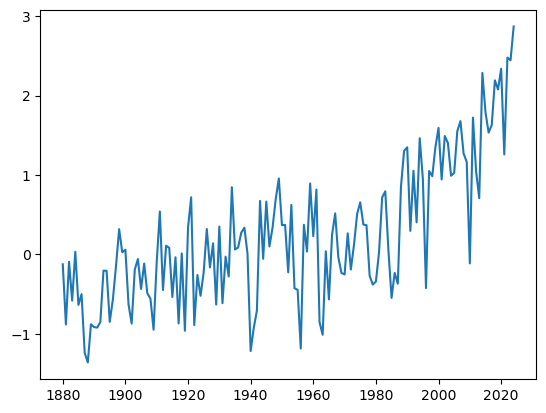

In [171]:
plt.plot(df_paris_yearly['Year'], df_paris_yearly['tempanomaly'])

In [172]:
df_paris_yearly.drop(columns=['Date'], inplace=True)

In [173]:
df_paris_yearly.to_csv('london_temperature_anomalies.csv', index=False)